The objective of this competition is to predict the probability that a customer does not pay back their credit card balance amount in the future based on their monthly customer profile. The target binary variable is calculated by observing 18 months performance window after the latest credit card statement, and if the customer does not pay due amount in 120 days after their latest statement date it is considered a default event.

The dataset contains aggregated profile features for each customer at each statement date. Features are anonymized and normalized, and fall into the following general categories:

    D_* = Delinquency variables
    S_* = Spend variables
    P_* = Payment variables
    B_* = Balance variables
    R_* = Risk variables

<a id = 1></a>
### 1. Loading Dataset 🔃

1) Dataset provided by AMEX is too big more than 50GB .. It cannot fit into memory 

2) Used dataset published by @Munum , who converted .csv file to .ftr(feather file) 

3) Real Dataset Size :

      Train_data.csv : 16.38 GB
      Test_data.csv :  33.82 GB
      Train_Lables.csv : 30.75 MB
      Sample_submission.csv : 61.95 MB
      
      
 4) Converted feather file size :
 
       Train_data.ftr : 3.45 GB
       Test_data.ftr :  6.96 GB
      
      

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from matplotlib.pyplot import figure

In [2]:
train_labels = pd.read_csv("../input/amex-default-prediction/train_labels.csv")

In [3]:
train_labels.head()

,customer_ID,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0
1,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,0
2,00001b22f846c82c51f6e3958ccd81970162bae8b007e8...,0
3,000041bdba6ecadd89a52d11886e8eaaec9325906c9723...,0
4,00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8a...,0


In [4]:
train_labels.shape

(458913, 2)

In [5]:
train_labels['target'].value_counts()

0    340085
1    118828
Name: target, dtype: int64

1) Real dataset 

In [6]:
df_train = pd.read_parquet("../input/amex-parquet/train_data.parquet")       

In [7]:
df_train.shape

(5531451, 191)

# EDA
* data duplication detection
* missing values
* group the same customer id

## 1) Distribution of target values

In [8]:
tmp = df_train['target'].value_counts().div(len(df_train)).mul(100)

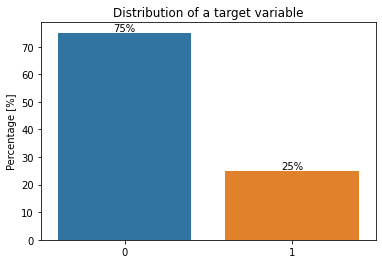

In [9]:
ax = sns.barplot(x=tmp.index, y=tmp.values)
ax.bar_label(ax.containers[0], fmt='%.f%%')
plt.title("Distribution of a target variable")
plt.ylabel("Percentage [%]")
plt.show()

It's clear that our dataset is unbalanced and this is a crucial point to keep in mind while modelling. 25% of customers had a default - it will be worth investigating these two groups separately to find some differences. First let's see how many unique customers do we have.

In [10]:
df_train[['customer_ID','target']].drop_duplicates(subset=['customer_ID'])

,customer_ID,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0
13,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,0
26,00001b22f846c82c51f6e3958ccd81970162bae8b007e8...,0
39,000041bdba6ecadd89a52d11886e8eaaec9325906c9723...,0
52,00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8a...,0
...,...,...
5531386,ffff41c8a52833b56430603969b9ca48d208e7c192c6a4...,0
5531399,ffff518bb2075e4816ee3fe9f3b152c57fc0e6f01bf7fd...,0
5531412,ffff9984b999fccb2b6127635ed0736dda94e544e67e02...,0
5531425,ffffa5c46bc8de74f5a4554e74e239c8dee6b9baf38814...,1


In [11]:
train_labels.shape

(458913, 2)

Comparing the length of df_train[['customer_ID','target']] and  train_labels, it is clear that though customer_ID can be repeated in df_train, but for the same 'customer_ID', the corresponding targets are same.

## 2) Missing values

In [12]:
tmp = df_train.isna().sum().div(len(df_train)).mul(100).sort_values(ascending=False)
miss_val = len(tmp[tmp>0])/len(tmp)*100
print(f'the percentage of the columns with missing values: {miss_val}%')

the percentage of the columns with missing values: 63.87434554973822%


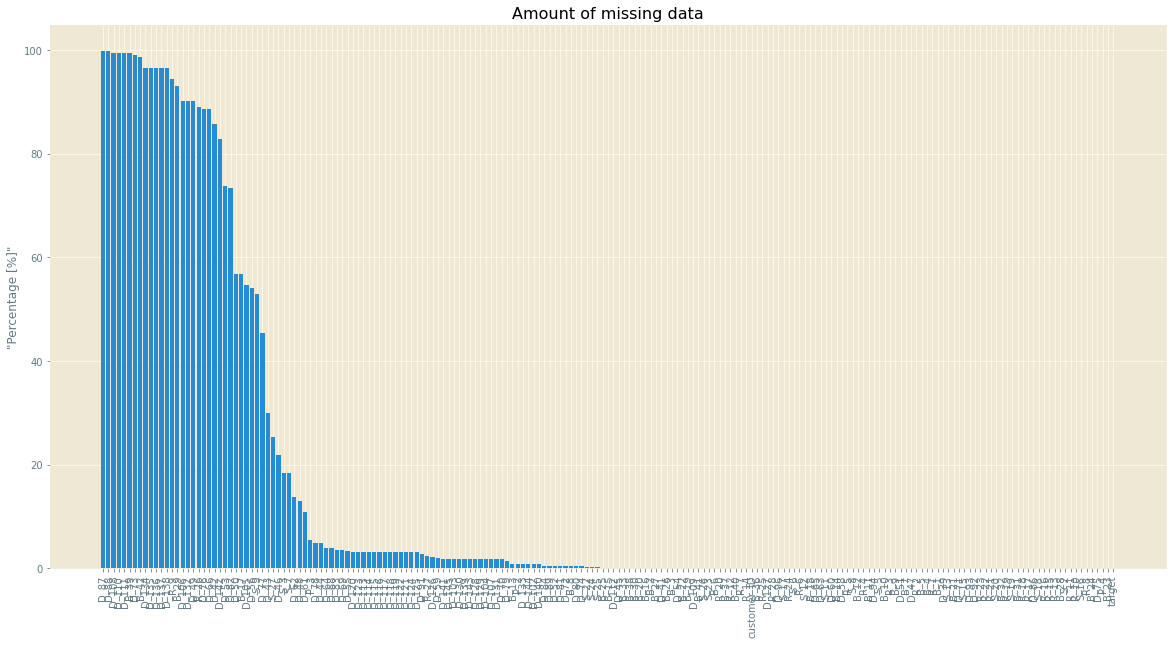

In [13]:
from matplotlib.pyplot import figure
figure(figsize=(20, 10))
plt.style.use('Solarize_Light2')
plt.bar(tmp.index, tmp.values)
plt.title('Amount of missing data')
plt.xticks(rotation=90)
plt.ylabel('"Percentage [%]"')
plt.show()

In [14]:
tmp[:30]

D_87     99.930127
D_88     99.891457
D_108    99.476846
D_110    99.433530
D_111    99.433530
B_39     99.391986
D_73     98.990211
B_42     98.707789
D_134    96.480146
D_135    96.480146
D_136    96.480146
D_137    96.480146
D_138    96.480146
R_9      94.349891
B_29     93.104594
D_106    90.213255
D_132    90.191055
D_49     90.137597
R_26     88.984717
D_76     88.746226
D_66     88.730733
D_42     85.694278
D_142    82.926577
D_53     73.842921
D_82     73.373406
D_50     56.809723
B_17     56.722874
D_105    54.622756
D_56     54.071581
S_9      53.035686
dtype: float64

In [15]:
# calculate the percentages: (for one colum, the corresponding sum count of target=1 of non-nan values)/
#(the corresponding total count of target=1 or target=0 of non-nan values) 
def del_no_miss(df_col):
    percentage = df_train[~df_col.isna()].target.sum()/len(df_train[~df_col.isna()])
    return(percentage)
# calculate the percentages: (for one column, the corresponding sum count of target=1 of nan values)/
#(the corresponding total count of target=1 or target=0 of nan values) 
def del_miss(df_col):
    percentage = df_train[df_col.isna()].target.sum()/len(df_train[df_col.isna()])
    return(percentage)

In [16]:
keys = tmp[:30].index
no_mis_values = []
mis_values = []
for i in keys:
    no_mis_values.append(del_no_miss(df_train[i]))
    mis_values.append(del_miss(df_train[i]))
miss_data = pd.DataFrame(no_mis_values, index=keys, columns=['no_miss_percent'])
miss_data['miss_percent'] = mis_values
print(miss_data)

       no_miss_percent  miss_percent
D_87          0.867012      0.248665
D_88          0.796136      0.248503
D_108         0.429124      0.248150
D_110         0.557892      0.247338
D_111         0.557892      0.247338
B_39          0.548377      0.247266
D_73          0.375269      0.247810
B_42          0.115658      0.250844
D_134         0.607281      0.236030
D_135         0.607281      0.236030
D_136         0.607281      0.236030
D_137         0.607281      0.236030
D_138         0.607281      0.236030
R_9           0.579033      0.229339
B_29          0.220093      0.251245
D_106         0.550107      0.216442
D_132         0.549830      0.216390
D_49          0.550052      0.216168
R_26          0.579678      0.208175
D_76          0.102400      0.267700
D_66          0.185524      0.257171
D_42          0.498217      0.207509
D_142         0.367016      0.224819
D_53          0.434077      0.183573
D_82          0.205855      0.264789
D_50          0.181441      0.300533
B

We can delete 'B_29' and 'D-82'. The percentages of their missing values are over 70%, and for the default percentages of their missing values and non-missing, the values are around 25%, which are close to the while data's default percentage.

## 3) Calculate correlation of 'D_*', 'S_*', 'P_*', 'B_*', 'R_*' respetively ( less memorry)

In [17]:
# count 'D_*', 'S_*', 'P_*', 'B_*', 'R_*'
alist = df_train.columns
D_percent = sum(map(lambda x : 1 if 'D_' in x else 0, alist))/len(alist)*100
S_percent = sum(map(lambda x : 1 if 'S_' in x else 0, alist))/len(alist)*100
P_percent = sum(map(lambda x : 1 if 'P_' in x else 0, alist))/len(alist)*100
B_percent = sum(map(lambda x : 1 if 'B_' in x else 0, alist))/len(alist)*100
R_percent = sum(map(lambda x : 1 if 'R_' in x else 0, alist))/len(alist)*100

print(f'D:{D_percent}%, S:{S_percent}%, P:{P_percent}%, B:{B_percent}%, R:{R_percent}%')

D:50.26178010471204%, S:11.518324607329843%, P:1.5706806282722512%, B:20.94240837696335%, R:14.659685863874344%


In [18]:

df_D = []
df_S = []
df_P = []
df_B = []
df_R = []
for i in alist:
    if 'D_' in i:
        df_D.append(i)
    if 'S_' in i:
        df_S.append(i)
    if 'P_' in i:
        df_P.append(i)
    if 'B_' in i:
        df_B.append(i)
    if 'R_' in i:
        df_R.append(i)

In [19]:
def func_corr(df):
    corrMatrix = df_train[df].corr()
    correlated_features = set()
    for i in range(len(corrMatrix.columns)):
        for j in range(i):
            if abs(corrMatrix.iloc[i, j]) > 0.9:
                colname = corrMatrix.columns[i]
                correlated_features.add(colname)
    return(correlated_features)

In [20]:
corrMatrix_D = func_corr(df_D)
corrMatrix_S = func_corr(df_S)
corrMatrix_P = func_corr(df_P)
corrMatrix_B = func_corr(df_B)
corrMatrix_R = func_corr(df_R)
#print (corrMatrix_D, corrMatrix_S, corrMatrix_P, corrMatrix_B, corrMatrix_R)
corr_list = list(corrMatrix_D)+list(corrMatrix_S)+list(corrMatrix_P)+list(corrMatrix_B)+list(corrMatrix_R)
corr_list

['D_143',
 'D_77',
 'D_119',
 'D_75',
 'D_104',
 'D_141',
 'D_74',
 'S_24',
 'S_7',
 'B_15',
 'B_11',
 'B_23',
 'B_33',
 'B_37']

We can remove these features:'D_75','D_74','D_119','D_77','D_104','D_143','D_141','S_7','S_24','B_33','B_23','B_15','B_37','B_11', because their correlation values are more than 0.9 (the biggist correlation value is 1) with some features of the stayed features in the data.

## 4) Categorical features

Columns in the dataset are divided by the organisers in the following groups:
D_*: Delinquency variables
S_*: Spend variables
P_*: Payment variables
B_*: Balance variables
R_*: Risk variables
Following features are categorical: B_30, B_38, D_63, D_64, D_66, D_68, D_114, D_116, D_117, D_120, D_126.

S_2: contains a timestamp

In [21]:
categorical_features = ['B_30', 'B_38', 'D_63', 'D_64', 'D_66', 'D_68', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'target']
df_train[categorical_features] = df_train[categorical_features].astype("str")
df_train[categorical_features].dtypes

B_30      object
B_38      object
D_63      object
D_64      object
D_66      object
D_68      object
D_114     object
D_116     object
D_117     object
D_120     object
D_126     object
target    object
dtype: object

In [22]:
#df_train[categorical_features].to_csv('amex_categorical_features1', index=False)

In [23]:
# the unique values per categorical column
for cf in categorical_features:
    print(cf, list(df_train[cf].unique()))

B_30 ['0.0', '2.0', '1.0', 'nan']
B_38 ['2.0', '1.0', '3.0', '5.0', '6.0', '7.0', '4.0', 'nan']
D_63 ['CR', 'CO', 'CL', 'XZ', 'XM', 'XL']
D_64 ['O', 'R', 'None', 'U', '-1']
D_66 ['nan', '1.0', '0.0']
D_68 ['6.0', '2.0', '3.0', 'nan', '5.0', '4.0', '0.0', '1.0']
D_114 ['1.0', '0.0', 'nan']
D_116 ['0.0', 'nan', '1.0']
D_117 ['4.0', '-1.0', '6.0', '2.0', '1.0', 'nan', '3.0', '5.0']
D_120 ['0.0', '1.0', 'nan']
D_126 ['1.0', 'nan', '0.0', '-1.0']
target ['0', '1']


In [24]:
df_train[['B_30', 'B_38', 'D_63', 'D_64', 'D_66', 'D_68', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126']].describe()

,B_30,B_38,D_63,D_64,D_66,D_68,D_114,D_116,D_117,D_120,D_126
count,5531451,5531451,5531451,5531451,5531451,5531451,5531451,5531451,5531451,5531451,5531451
unique,4,8,6,5,3,8,3,3,8,3,4
top,0.0,2.0,CO,O,nan,6.0,1.0,0.0,-1.0,0.0,1.0
freq,4710663,1953232,4119621,2913244,4908097,2782455,3316478,5348109,1456084,4729723,4262414


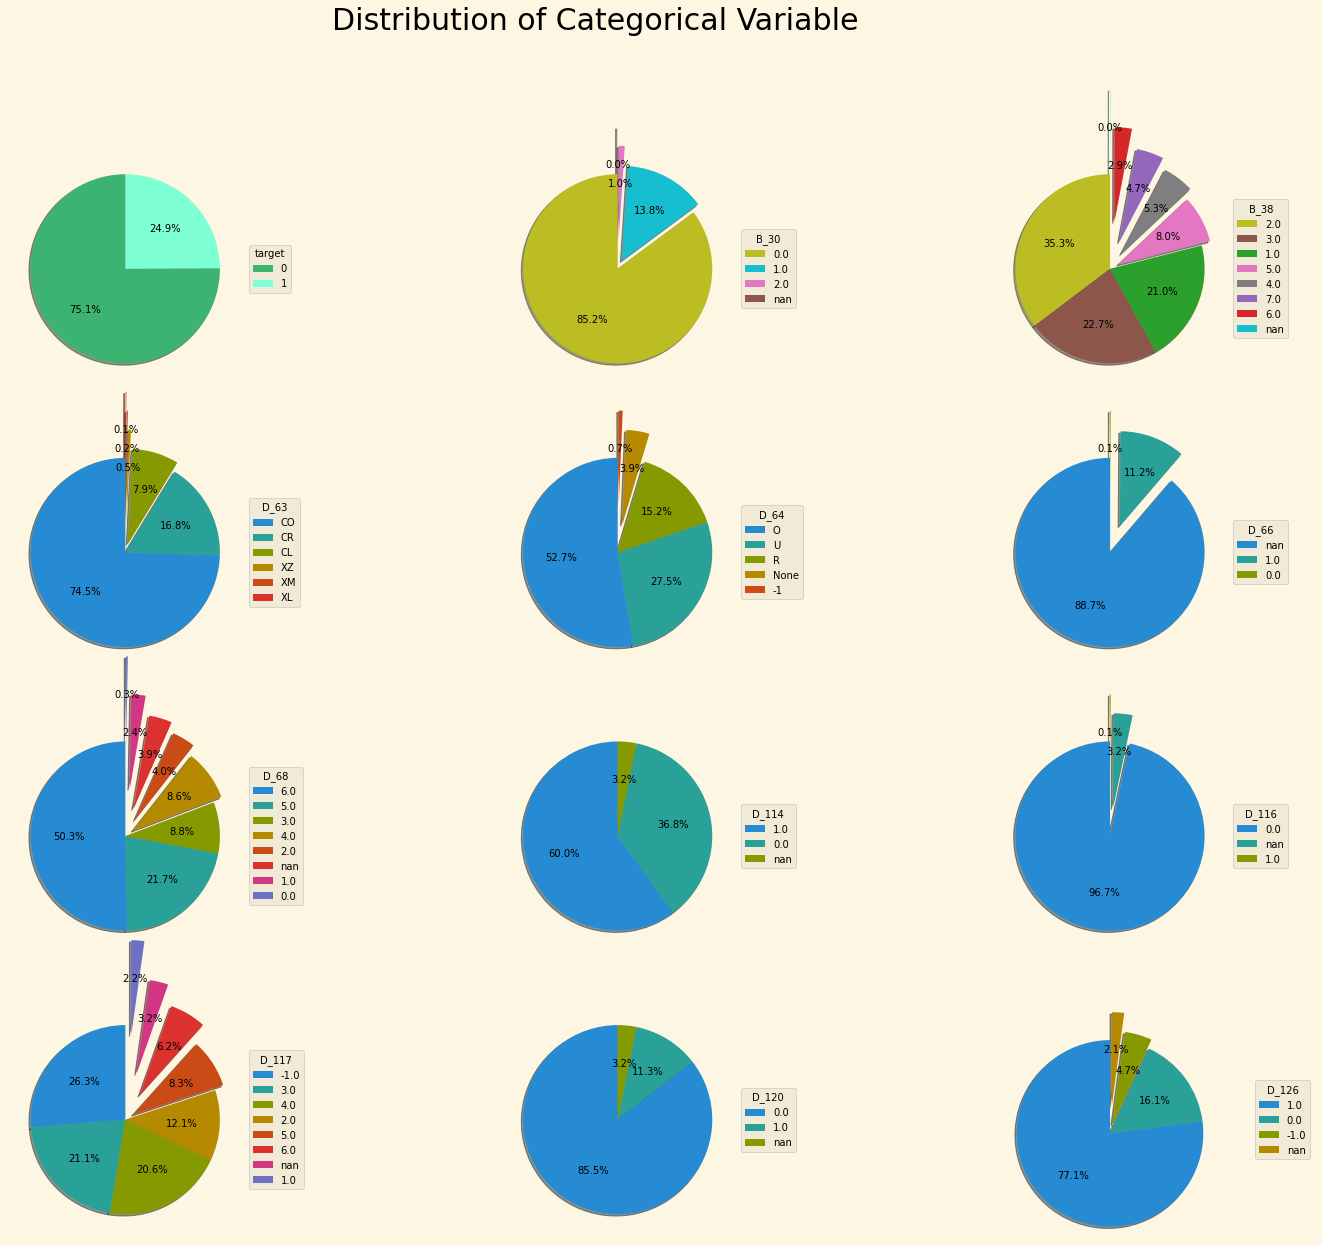

In [25]:
# the distribution for Categorical Variable
# plot distribution of categorical variables
fig,((ax1,ax2,ax3),(ax4,ax5,ax6),(ax7,ax8,ax9),(ax10,ax11,ax12)) = plt.subplots(4,3,figsize=(25,20))
fig.suptitle('Distribution of Categorical Variable',fontsize=30)

ax1.pie(df_train['target'].value_counts(dropna=False), autopct='%1.1f%%',shadow=True, startangle=90, colors={'aquamarine','mediumseagreen'})
ax1.legend(labels = df_train['target'].value_counts(dropna=False).index, loc ='center left', bbox_to_anchor=(1, 0.5), title ='target',frameon = True)

ax2.pie(df_train['B_30'].value_counts(dropna=False), autopct='%1.1f%%',shadow=True, startangle=90,explode=(0.0,0.1,0.3,0.5), colors={'tab:cyan','tab:olive','tab:pink','tab:brown'})
ax2.legend(labels = df_train['B_30'].value_counts(dropna=False).index, loc ='center left', bbox_to_anchor=(1, 0.5), title ='B_30',frameon = True)

ax3.pie(df_train['B_38'].value_counts(dropna=False), autopct='%1.1f%%',shadow=True, startangle=90,explode=(0.0,0.0,0.0,0.1,0.2,0.3,0.5,0.9),colors={'tab:cyan','tab:olive','tab:pink','tab:brown','tab:gray','tab:purple','tab:red','tab:green'})
ax3.legend(labels = df_train['B_38'].value_counts(dropna=False).index, loc ='center left', bbox_to_anchor=(1, 0.5), title ='B_38',frameon = True)

ax4.pie(df_train['D_63'].value_counts(dropna=False), autopct='%1.1f%%',shadow=True, startangle=90, explode=(0.0,0.0,0.1,0.3,0.5,0.7))
ax4.legend(labels = df_train['D_63'].value_counts(dropna=False).index, loc ='center left', bbox_to_anchor=(1, 0.5),title ='D_63',frameon = True)

ax5.pie(df_train['D_64'].value_counts(dropna=False), autopct='%1.1f%%',shadow=True, startangle=90,explode=(0.0,0.0,0.0,0.3,0.5))
ax5.legend(labels = df_train['D_64'].value_counts(dropna=False).index, loc ='center left', bbox_to_anchor=(1, 0.5), title ='D_64',frameon = True)

ax6.pie(df_train['D_66'].value_counts(dropna=False), autopct='%1.1f%%',shadow=True, startangle=90,explode=(0.0,0.3,0.5))
ax6.legend(labels = df_train['D_66'].value_counts(dropna=False).index, loc ='center left', bbox_to_anchor=(1, 0.5), title ='D_66',frameon = True)

ax7.pie(df_train['D_68'].value_counts(dropna=False), autopct='%1.1f%%',shadow=True, startangle=90,explode=(0.0,0.0,0.0,0.1,0.2,0.3,0.5,0.9))
ax7.legend(labels = df_train['D_68'].value_counts(dropna=False).index, loc ='center left', bbox_to_anchor=(1, 0.5), title ='D_68',frameon = True)

ax8.pie(df_train['D_114'].value_counts(dropna=False), autopct='%1.1f%%',shadow=True, startangle=90)
ax8.legend(labels = df_train['D_114'].value_counts(dropna=False).index, loc ='center left', bbox_to_anchor=(1, 0.5), title ='D_114',frameon = True)

ax9.pie(df_train['D_116'].value_counts(dropna=False), autopct='%1.1f%%',shadow=True, startangle=90,explode=(0.0,0.3,0.5))
ax9.legend(labels = df_train['D_116'].value_counts(dropna=False).index, loc ='center left', bbox_to_anchor=(1, 0.5), title ='D_116',frameon = True)

ax10.pie(df_train['D_117'].value_counts(dropna=False), autopct='%1.1f%%',shadow=True, startangle=90,explode=(0.0,0.0,0.0,0.0,0.1,0.3,0.5,0.9))
ax10.legend(labels = df_train['D_117'].value_counts(dropna=False).index, loc ='center left', bbox_to_anchor=(1, 0.5), title ='D_117',frameon = True)

ax11.pie(df_train['D_120'].value_counts(dropna=False), autopct='%1.1f%%',shadow=True, startangle=90)
ax11.legend(labels = df_train['D_120'].value_counts(dropna=False).index, loc ='center left', bbox_to_anchor=(1, 0.5), title ='D_120',frameon = True)

ax12.pie(df_train['D_126'].value_counts(dropna=False), autopct='%1.1f%%',shadow=True, startangle=90,explode=(0.0,0.0,0.1,0.3))
ax12.legend(labels = df_train['D_126'].value_counts(dropna=False).index, loc ='center right', title ='D_126',frameon = True)

plt.axis('equal')
fig.show()

In order to clearly observe the relationships of features to features, features to targets, I also use powerbi to display the visual interaction options. In another notebook, I shows the results of power BI and discussion.

## 4) Timestamp of custumer analysis

In [26]:
df_train['S_2'] = pd.to_datetime(df_train['S_2'])

In [27]:
print(f'Train dates range is from {df_train["S_2"].min()} to {df_train["S_2"].max()}.')

Train dates range is from 2017-03-01 00:00:00 to 2018-03-31 00:00:00.


In [28]:
df_train_time = df_train[~df_train.duplicated('customer_ID',keep=False)].sort_values(by='S_2')

In [29]:
df_train_time.head()

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
1462969,4363c1f757573224396cb8e5dc7ae843cff3ba71d9144e...,2018-03-01,0.637957,0.009711,0.070743,0.811217,0.000418,0.341654,0.004326,0.004237,...,NaN,NaN,0.000056,0.006864,0.001114,NaN,0.002707,0.003968,0.007936,0
2242751,67a19b66a663910ec5d073e006788076dc4f382a2f58af...,2018-03-01,0.506360,0.007607,0.009536,0.817761,0.008091,0.321725,0.009474,0.003593,...,NaN,NaN,0.002722,0.000102,0.006295,NaN,0.009731,0.003492,0.006624,0
2235103,6748e568ff33eb7f6b6de2b4236c395fad9cba764f780f...,2018-03-01,0.348939,0.001580,0.031524,0.814125,0.502165,0.430684,0.000818,0.001448,...,NaN,NaN,0.003691,0.001248,0.006881,NaN,0.001181,0.008186,0.007501,0
3332276,99f6625e9884c0c1e6f7754c92d6ea89e43e94f5f1adf2...,2018-03-01,NaN,0.001540,0.002200,0.813513,0.009743,0.372339,0.004027,0.006099,...,NaN,NaN,0.003036,0.002154,0.003350,NaN,0.006451,0.007546,0.005591,0
3402474,9d3304d92dcfdef704232d1ebafe6ede53e21ce8b92c78...,2018-03-01,0.920494,0.005819,0.013349,0.814178,0.007411,0.162636,0.006904,0.004001,...,NaN,NaN,0.005349,0.009065,0.002919,NaN,0.008915,0.006633,0.006646,0


In [30]:
df_train_time.target.value_counts()

0    3401
1    1719
Name: target, dtype: int64

For this data, if customers applied Amex card after 2017-12-01 (in the former table, it shows customers first applied Amex card sfter 2018--03-01), their targets are not considered as default evenets. For in the description of this competition, it says, if the customer does not pay due amount in 120 days after their latest statement date it is considered a default event.